## 2D Navier Stokes

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

## Low Resolution Attempt

In [2]:
# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 32)

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
plot(mesh)

In [6]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""


T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes_cylinder/lowres_velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes_cylinder/lowres_pressure.xdmf')

# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes_cylinder/lowres_velocity_series')
timeseries_p = TimeSeries('navier_stokes_cylinder/lowres_pressure_series')

# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/lowres_cylinder.xml.gz') << mesh

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)


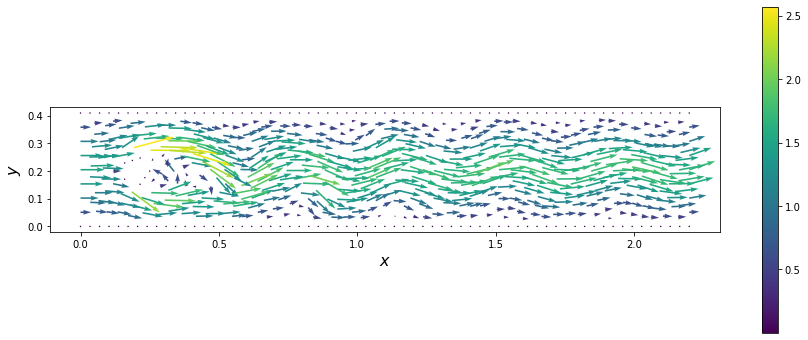

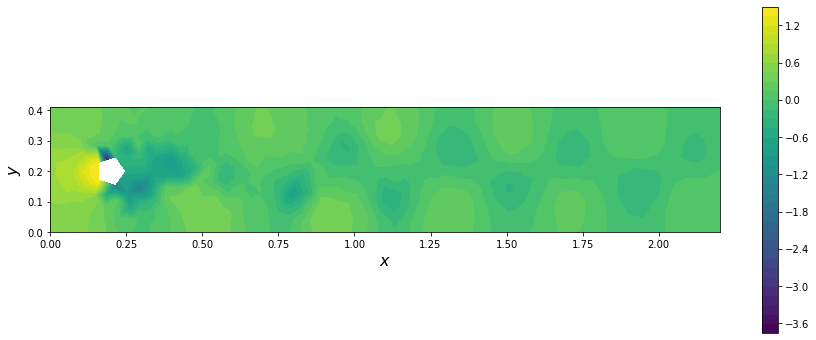

In [7]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(u_)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(p_)
fig.colorbar(tpc)

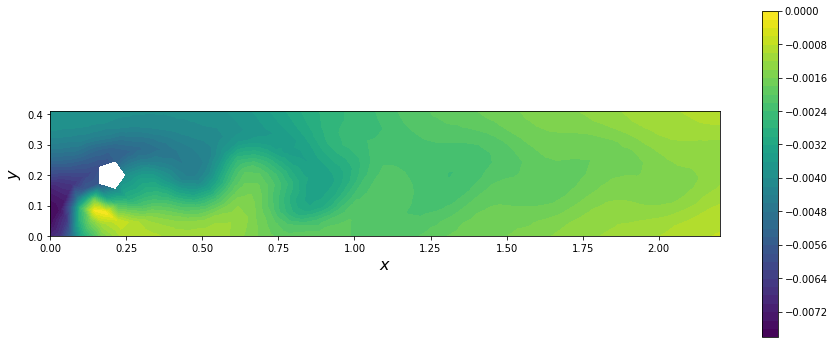

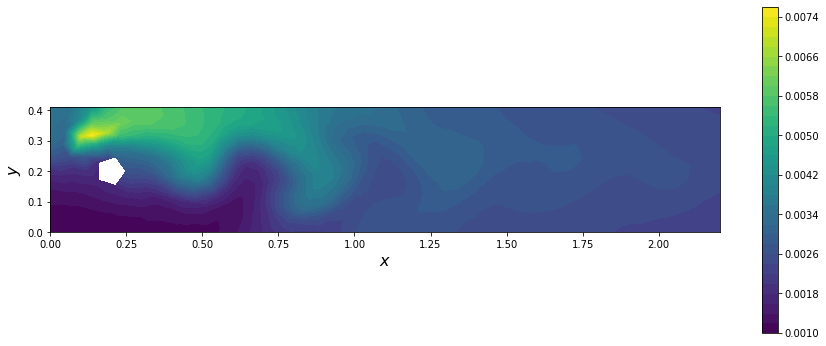

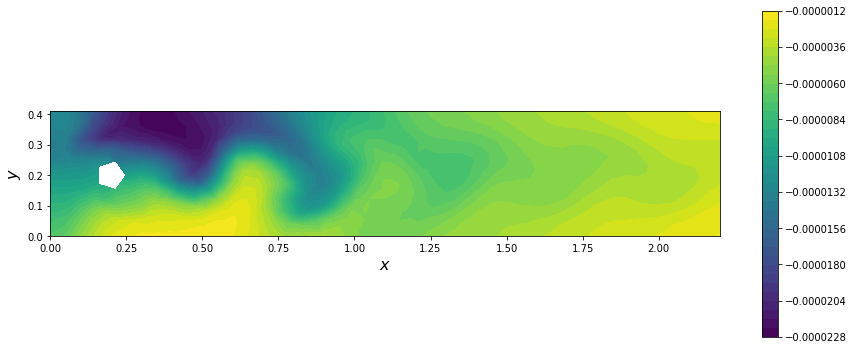

In [8]:
"""
FEniCS tutorial demo program: Convection-diffusion-reaction for a system
describing the concentration of three species A, B, C undergoing a simple
first-order reaction A + B --> C with first-order decay of C. The velocity
is given by the flow field w from the demo navier_stokes_cylinder.py.

  u_1' + w . nabla(u_1) - div(eps*grad(u_1)) = f_1 - K*u_1*u_2
  u_2' + w . nabla(u_2) - div(eps*grad(u_2)) = f_2 - K*u_1*u_2
  u_3' + w . nabla(u_3) - div(eps*grad(u_3)) = f_3 + K*u_1*u_2 - K*u_3

"""



T = 5            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Read mesh from file
mesh = Mesh('navier_stokes_cylinder/lowres_cylinder.xml.gz')

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
w = Function(W)
u = Function(V)
u_n = Function(V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

# Define expressions used in variational forms
k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx \
    + ((u_2 - u_n2) / k)*v_2*dx \
    + ((u_3 - u_n3) / k)*v_3*dx
F += dot(w, grad(u_1))*v_1*dx \
    + dot(w, grad(u_2))*v_2*dx \
    + dot(w, grad(u_3))*v_3*dx
F += eps*dot(grad(u_1), grad(v_1))*dx \
    + eps*dot(grad(u_2), grad(v_2))*dx \
    + eps*dot(grad(u_3), grad(v_3))*dx
F += K*u_1*u_2*v_1*dx  \
    + K*u_1*u_2*v_2*dx  \
    - K*u_1*u_2*v_3*dx \
    + K*u_3*v_3*dx
F += - f_1*v_1*dx \
    - f_2*v_2*dx \
    - f_3*v_3*dx

# Create time series for reading velocity data
timeseries_w = TimeSeries('navier_stokes_cylinder/lowres_velocity_series')


# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()


    # Update previous solution
    u_n.assign(u)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_1)
fig.colorbar(tpc)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_2)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_3)
fig.colorbar(tpc)

## Original Code

In [ ]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""


T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Create XDMF files for visualization output
xdmffile_u = XDMFFile('navier_stokes_cylinder/velocity.xdmf')
xdmffile_p = XDMFFile('navier_stokes_cylinder/pressure.xdmf')

# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('navier_stokes_cylinder/velocity_series')
timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')

# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh

# Create progress bar
# progress = Progress('Time-stepping') # NO LONGER SUPPORTED?
# set_log_level(PROGRESS) # NO LONGER SUPPORTED?

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')
    
#     print("solved @ time: ", t)
#     # Plot solution
#     plot(u_, title='Velocity')
#     plot(p_, title='Pressure')

    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t)

    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    timeseries_p.store(p_.vector(), t)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Update progress bar
#     progress.update(t / T)
#     print('u max:', u_.vector().array().max())

# Hold plot
#interactive() NO LONGER SUPPORTED

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(u_)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(p_)
fig.colorbar(tpc)

In [ ]:
print(u_1, u_2, u_3)

In [1]:
solve?

Object `solve` not found.


## Coupled Reaction Equations

In [5]:
"""
FEniCS tutorial demo program: Convection-diffusion-reaction for a system
describing the concentration of three species A, B, C undergoing a simple
first-order reaction A + B --> C with first-order decay of C. The velocity
is given by the flow field w from the demo navier_stokes_cylinder.py.

  u_1' + w . nabla(u_1) - div(eps*grad(u_1)) = f_1 - K*u_1*u_2
  u_2' + w . nabla(u_2) - div(eps*grad(u_2)) = f_2 - K*u_1*u_2
  u_3' + w . nabla(u_3) - div(eps*grad(u_3)) = f_3 + K*u_1*u_2 - K*u_3

"""



T = 5            # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size
eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Read mesh from file
mesh = Mesh('navier_stokes_cylinder/cylinder.xml.gz')

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V)

# Define functions for velocity and concentrations
w = Function(W)
u = Function(V)
u_n = Function(V)

# Split system functions to access components
u_1, u_2, u_3 = split(u)
u_n1, u_n2, u_n3 = split(u_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

# Define expressions used in variational forms
k = Constant(dt)
K = Constant(K)
eps = Constant(eps)

# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx \
    + ((u_2 - u_n2) / k)*v_2*dx \
    + ((u_3 - u_n3) / k)*v_3*dx
F += dot(w, grad(u_1))*v_1*dx \
    + dot(w, grad(u_2))*v_2*dx \
    + dot(w, grad(u_3))*v_3*dx
F += eps*dot(grad(u_1), grad(v_1))*dx \
    + eps*dot(grad(u_2), grad(v_2))*dx \
    + eps*dot(grad(u_3), grad(v_3))*dx
F += K*u_1*u_2*v_1*dx  \
    + K*u_1*u_2*v_2*dx  \
    - K*u_1*u_2*v_3*dx \
    + K*u_3*v_3*dx
F += - f_1*v_1*dx \
    - f_2*v_2*dx \
    - f_3*v_3*dx

# Create time series for reading velocity data
timeseries_w = TimeSeries('navier_stokes_cylinder/velocity_series')


# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Read velocity from file
    timeseries_w.retrieve(w.vector(), t)

    # Solve variational problem for time step
    solve(F == 0, u)

    # Save solution to file (VTK)
    _u_1, _u_2, _u_3 = u.split()


    # Update previous solution
    u_n.assign(u)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_1)
fig.colorbar(tpc)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_2)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(_u_3)
fig.colorbar(tpc)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to open file.
*** Reason:  Unknown file type (".msh") for file "flow_past_cylinder.msh".
*** Where:   This error was encountered inside File.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  473fc681d80577c29aa757c3b36ffec0b3f067e9
*** -------------------------------------------------------------------------


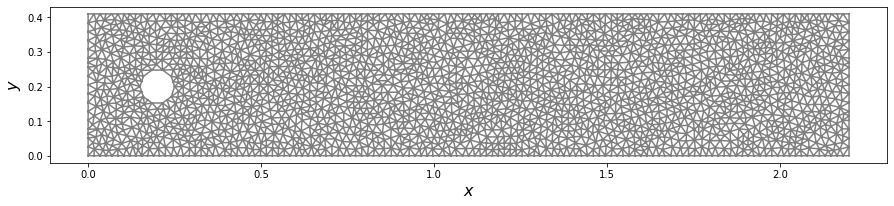

In [11]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
plot(mesh)

In [ ]:
print(u.split)
print(split(u))

In [ ]:
print(u_1, _u_1, u_2, _u_2, u_3, _u_3)

In [ ]:
TestFunctions?

In [ ]:
print(_u_2.compute_vertex_values(mesh))

In [ ]:
timeseries_w.retrieve?

### Fenics Combined Implementation

In [ ]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""


T = 5.0            # final time
num_steps = 5000   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# Create mesh
channel = Rectangle(Point(0, 0), Point(2.2, 0.41))
cylinder = Circle(Point(0.2, 0.2), 0.05)
domain = channel - cylinder
mesh = generate_mesh(domain, 64)

# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# Define boundaries
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2.2)'
walls    = 'near(x[1], 0) || near(x[1], 0.41)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'

# Define inflow profile
inflow_profile = ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0')

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

eps = 0.01         # diffusion coefficient
K = 10.0           # reaction rate

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 2)

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
H = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(H)

# Define functions for velocity and concentrations
c = Function(H)
c_n = Function(H)

# Split system functions to access components
c_1, c_2, c_3 = split(c)
c_n1, c_n2, c_n3 = split(c_n)

# Define source terms
f_1 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.1,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_2 = Expression('pow(x[0]-0.1,2)+pow(x[1]-0.3,2)<0.05*0.05 ? 0.1 : 0',
                 degree=1)
f_3 = Constant(0)

# Define expressions used in variational forms
K = Constant(K)
eps = Constant(eps)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Define variational problem
F = ((c_1 - c_n1) / k)*v_1*dx \
    + ((c_2 - c_n2) / k)*v_2*dx \
    + ((c_3 - c_n3) / k)*v_3*dx
F += dot(u_, grad(c_1))*v_1*dx \
    + dot(u_, grad(c_2))*v_2*dx \
    + dot(u_, grad(c_3))*v_3*dx
F += eps*dot(grad(c_1), grad(v_1))*dx \
    + eps*dot(grad(c_2), grad(v_2))*dx \
    + eps*dot(grad(c_3), grad(v_3))*dx
F += K*c_1*c_2*v_1*dx  \
    + K*c_1*c_2*v_2*dx  \
    - K*c_1*c_2*v_3*dx \
    + K*c_3*v_3*dx
F += - f_1*v_1*dx \
    - f_2*v_2*dx \
    - f_3*v_3*dx

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
b1 = assemble(L1)
[bc.apply(b1) for bc in bcu]
b2 = assemble(L2)
[bc.apply(b2) for bc in bcp]
b3 = assemble(L3)

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
   
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

    # Solve variational problem for time step
    solve(F == 0, c)

    # Save solution to file (VTK)
    _c_1, _c_2, _c_3 = c.split()


    # Update previous solution
    c_n.assign(c)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_1)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_2)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_3)
fig.colorbar(tpc)

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_1)
fig.colorbar(tpc)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_2)
fig.colorbar(tpc)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
tpc = plot(c_3)
fig.colorbar(tpc)

In [ ]:
MixedElement?